In [1]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import os
from util import categorize_kda

PATH = 'data'

train = pd.read_csv(os.path.join(PATH, 'train.csv'))
print(train.shape)

(12879, 10)


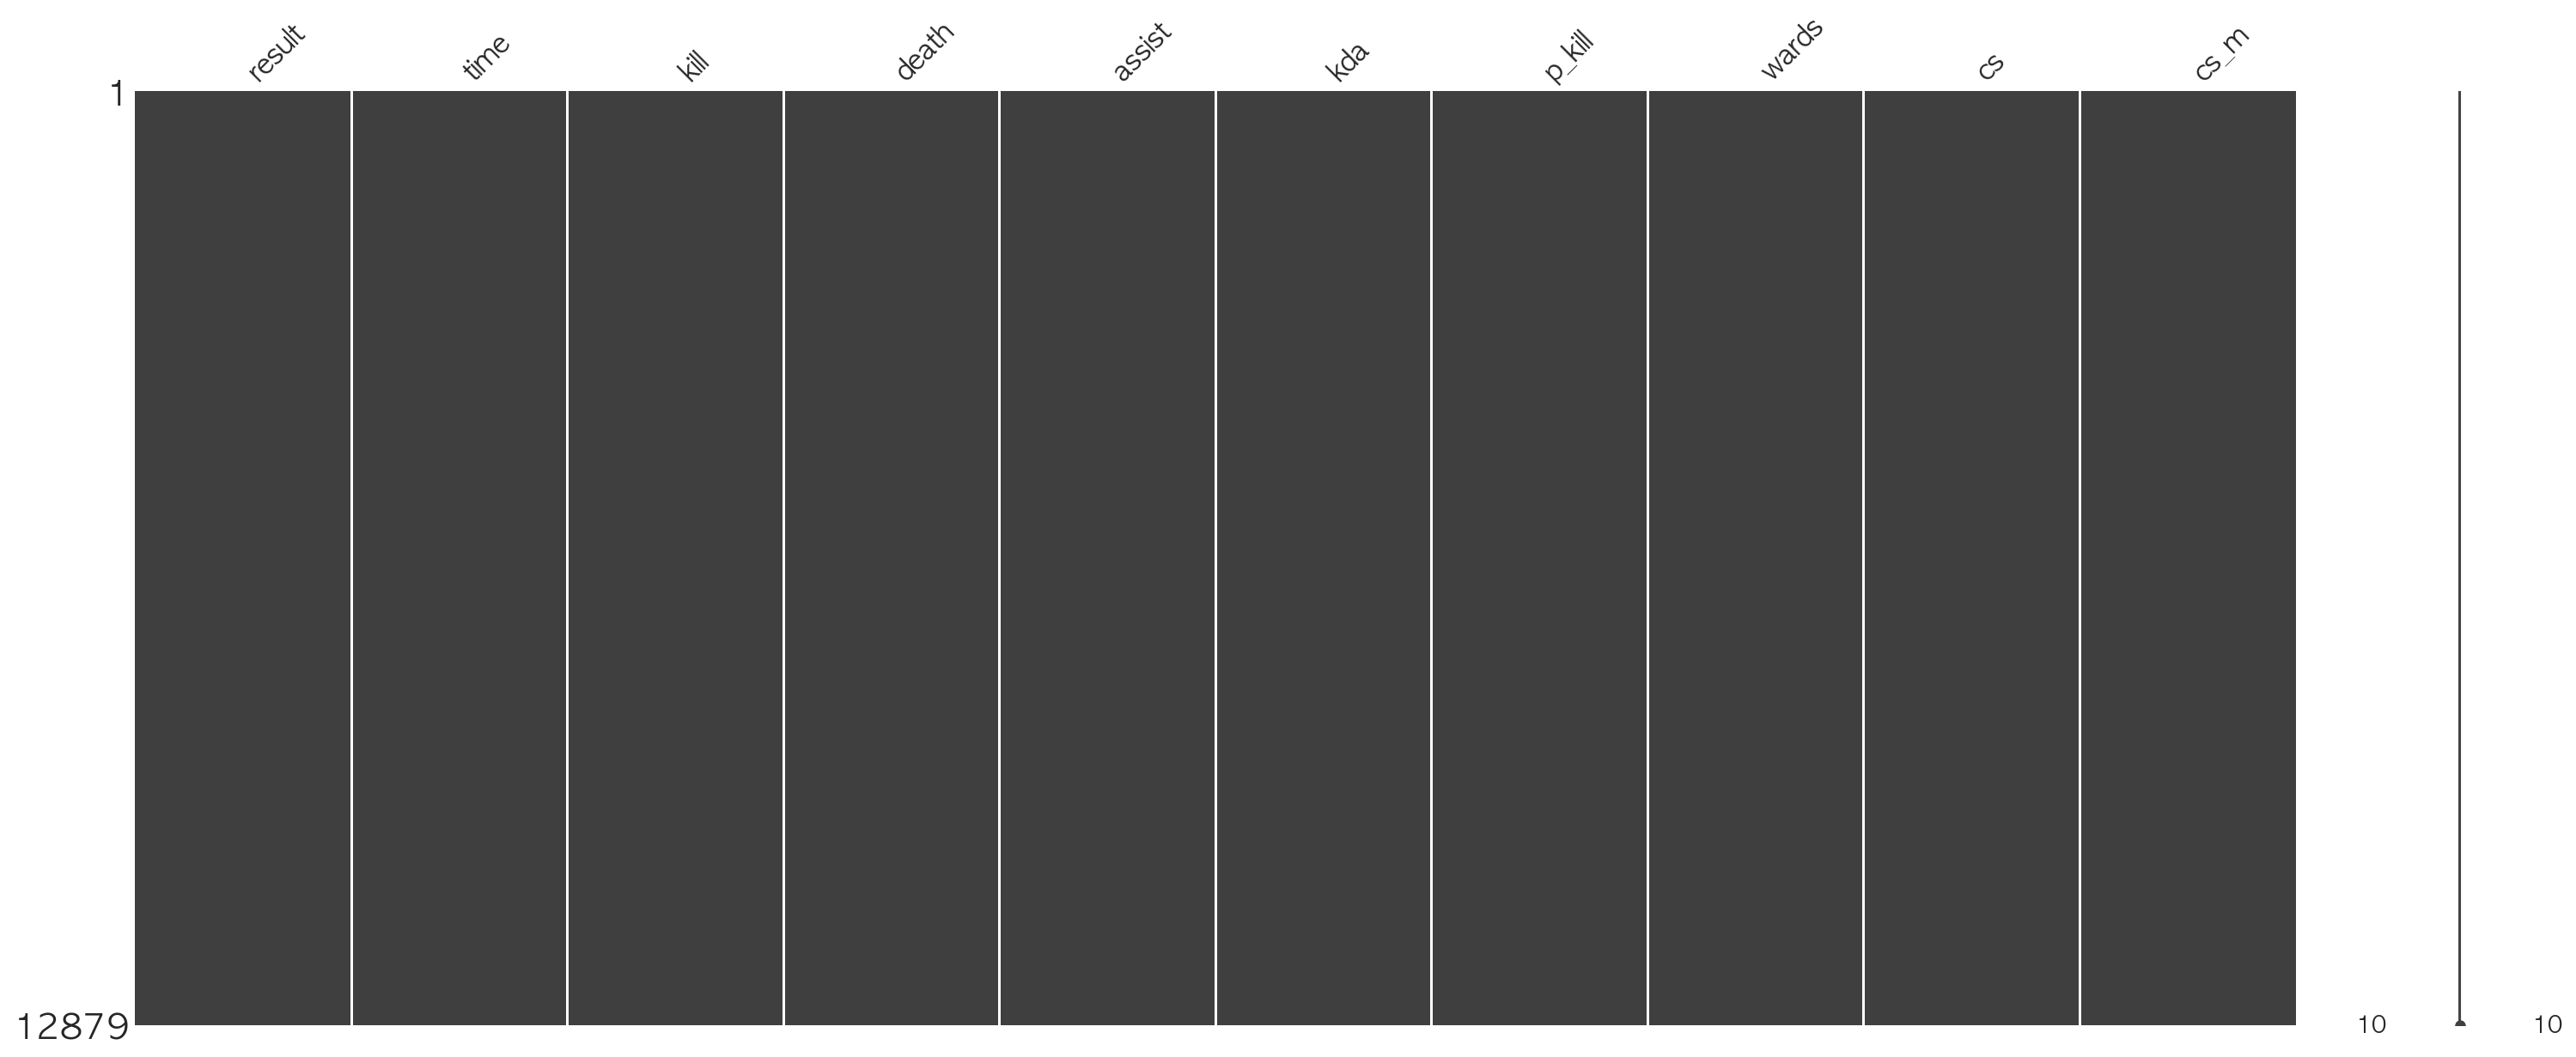

In [2]:
msno.matrix(train)

In [3]:
train.head()

,result,time,kill,death,assist,kda,p_kill,wards,cs,cs_m
0,Victory,29.58,6.0,1.0,10.0,16.000000,0.76,3.0,197.0,6.7
1,Defeat,29.78,4.0,8.0,6.0,1.250000,0.56,1.0,206.0,6.9
2,Victory,24.95,8.0,3.0,2.0,3.330000,0.36,3.0,201.0,8.1
3,Victory,11.18,4.0,0.0,1.0,inf,0.31,2.0,87.0,7.8
4,Defeat,15.28,0.0,7.0,1.0,0.140000,0.11,1.0,53.0,3.5


In [4]:
train_cols = train.iloc[:, 1:].columns
train_cols

Index(['time', 'kill', 'death', 'assist', 'kda', 'p_kill', 'wards', 'cs',
       'cs_m'],
      dtype='object')

## 1. 승패와 Kill/Death/Assist의 상관관계

- 승리 시에 Kill/Assist 모두 증가
- 패배 시에는 Death가 더 많이 발생
- Kill/Death/Assist 사이의 상관관계는 약함

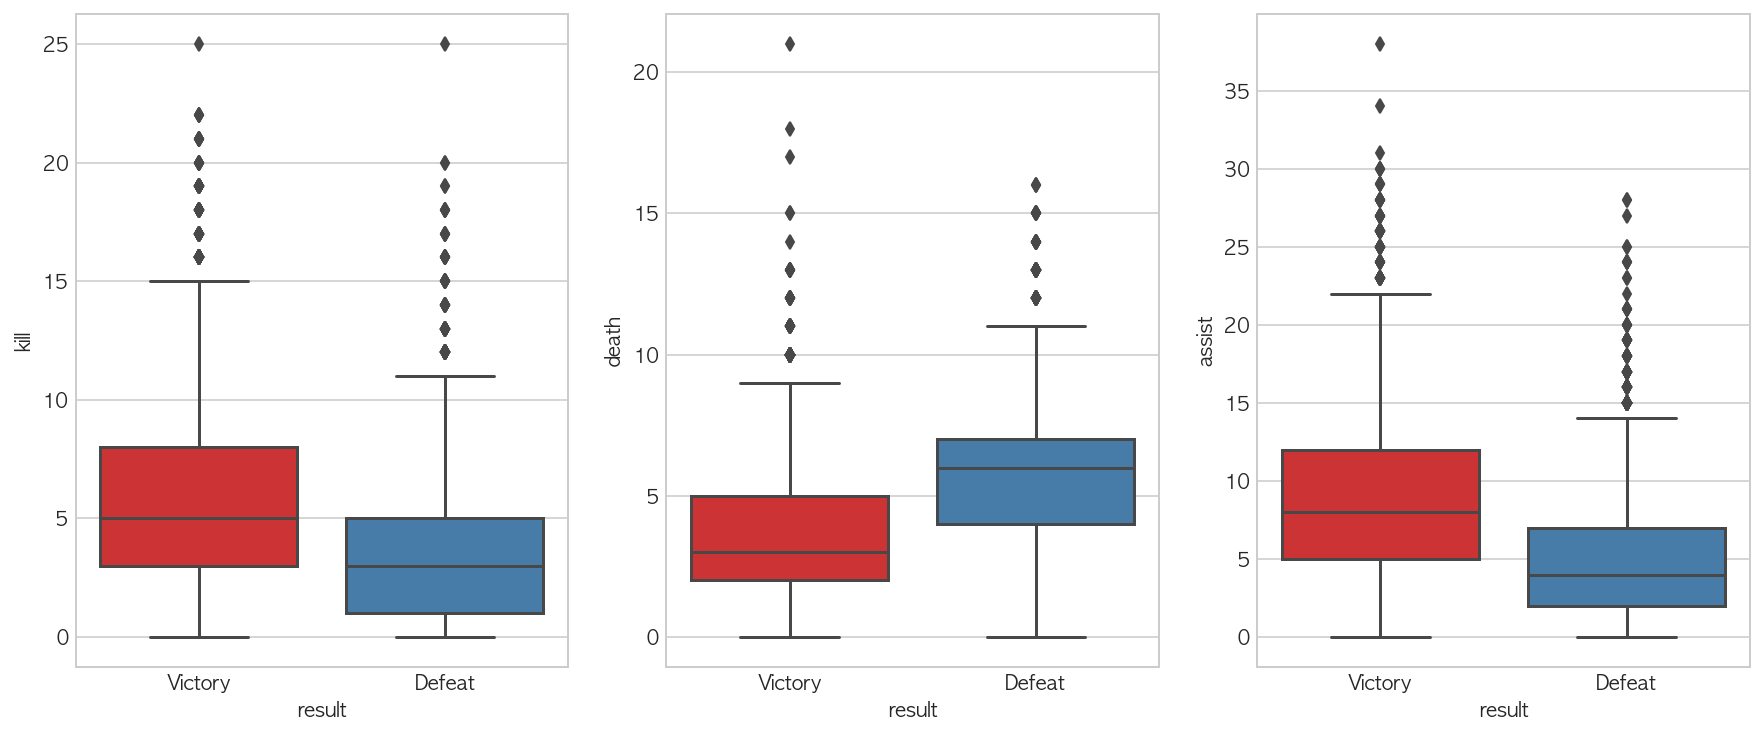

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

sns.boxplot(x=train['result'], y=train['kill'], palette='Set1', ax=axes[0])
sns.boxplot(x=train['result'], y=train['death'], palette='Set1', ax=axes[1])
sns.boxplot(x=train['result'], y=train['assist'], palette='Set1', ax=axes[2])

plt.show()

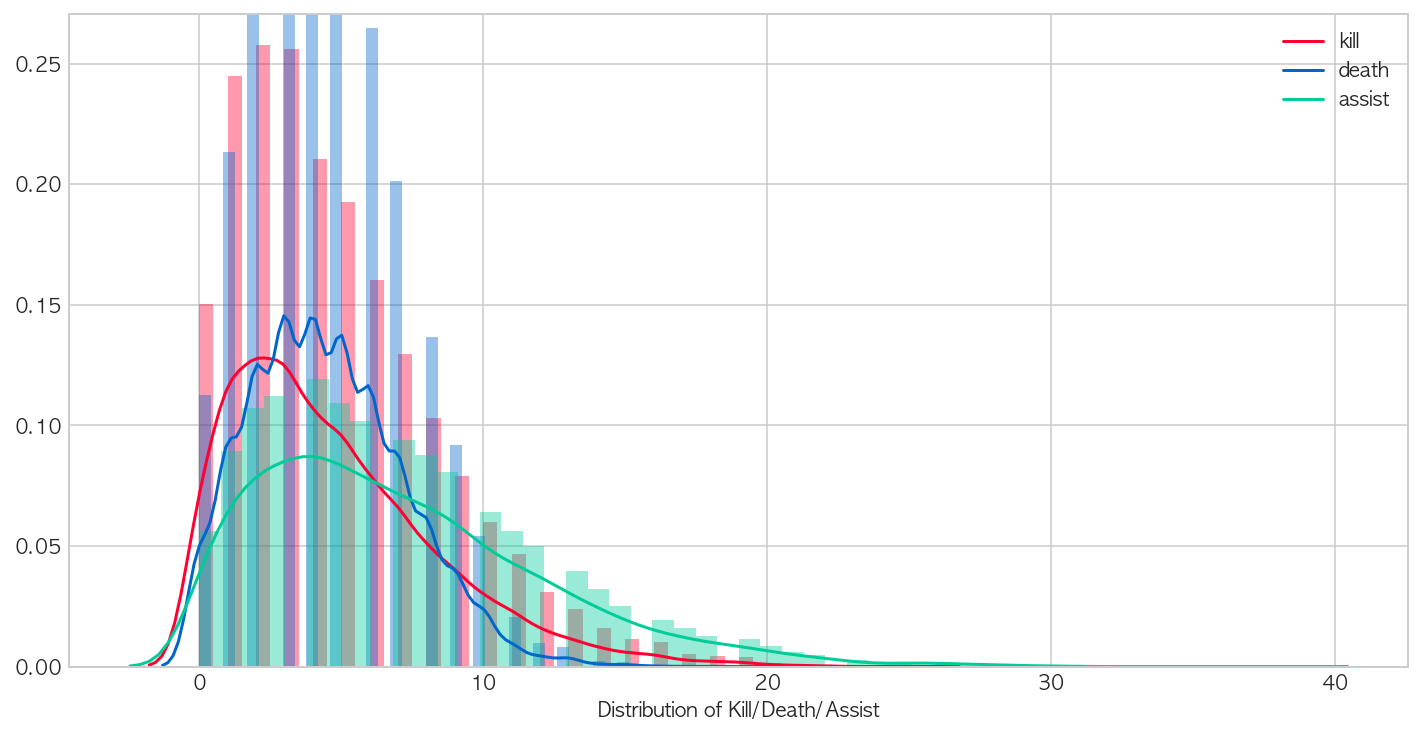

In [6]:
cols = ['kill', 'death', 'assist']
colors = ['#ff0033', '#0066cc', '#00cc99']

plt.figure(figsize=(12, 6))
for col, color in zip(cols, colors):
    sns.distplot(train[col], color=color, kde_kws={'label': col})
plt.xlabel('Distribution of Kill/Death/Assist')
plt.show()

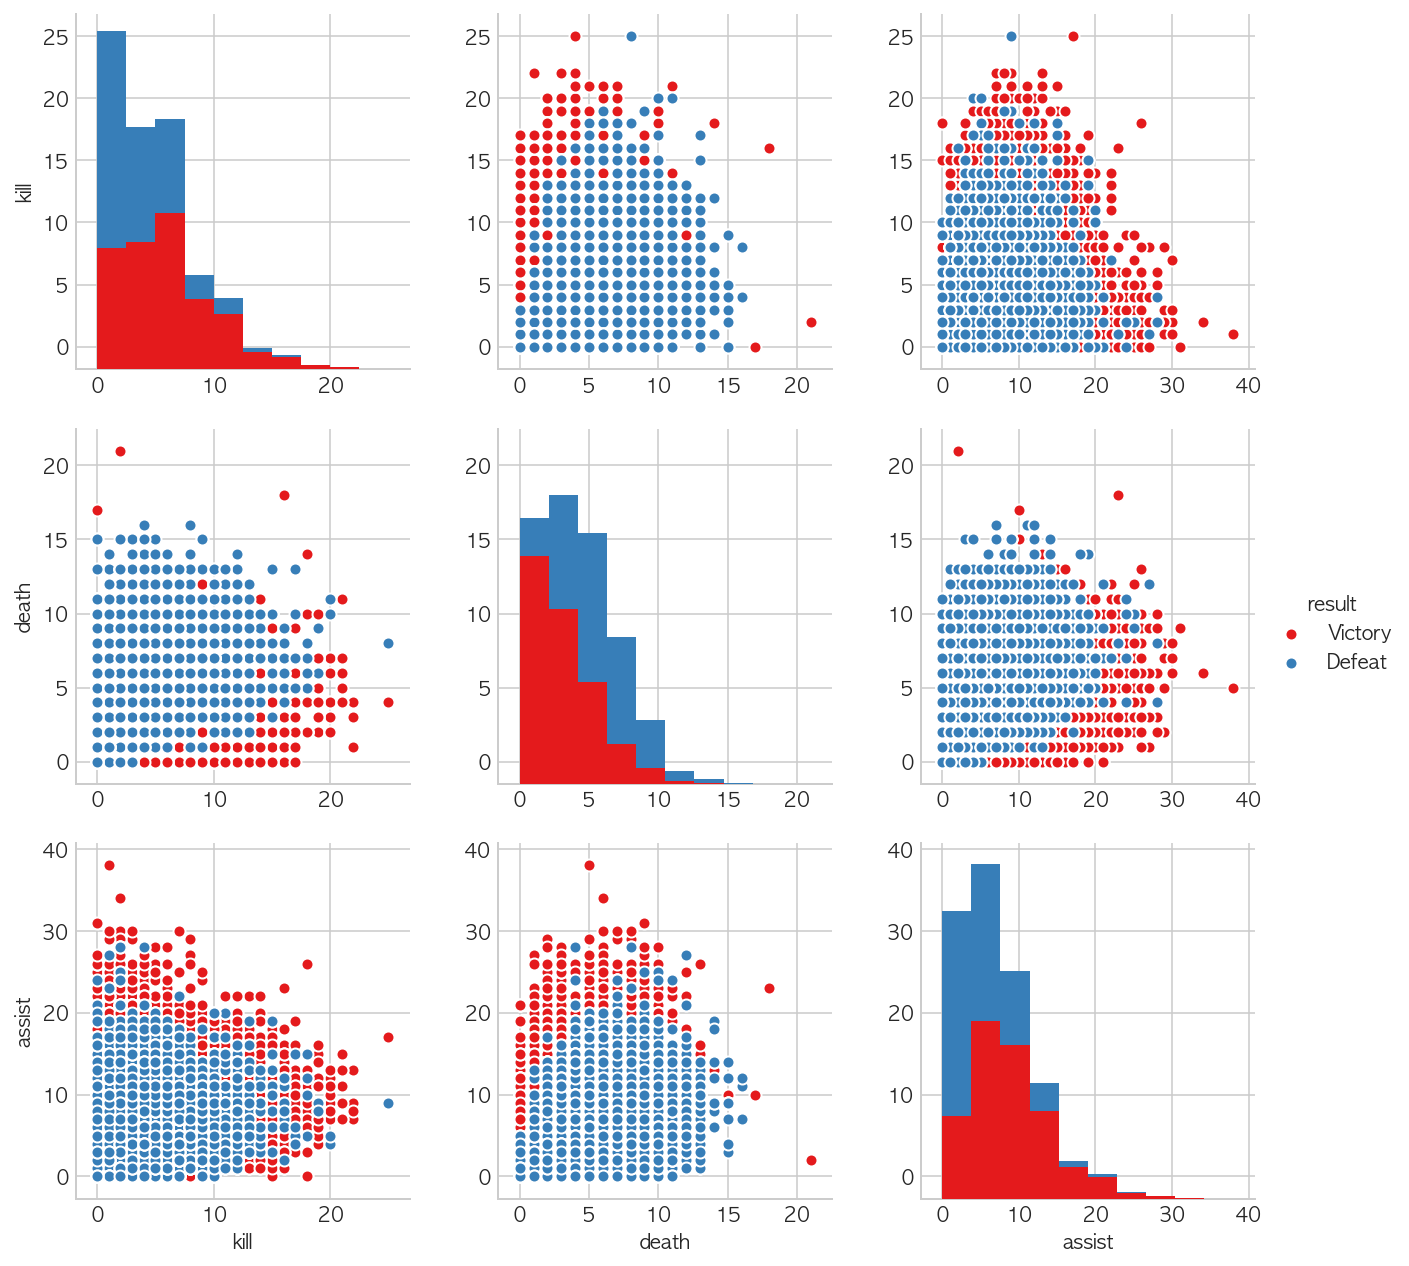

In [7]:
train_kda =  train.loc[:, ['kill', 'death', 'assist', 'result']]

sns.pairplot(train_kda, hue='result', palette='Set1', size=3)
plt.show()

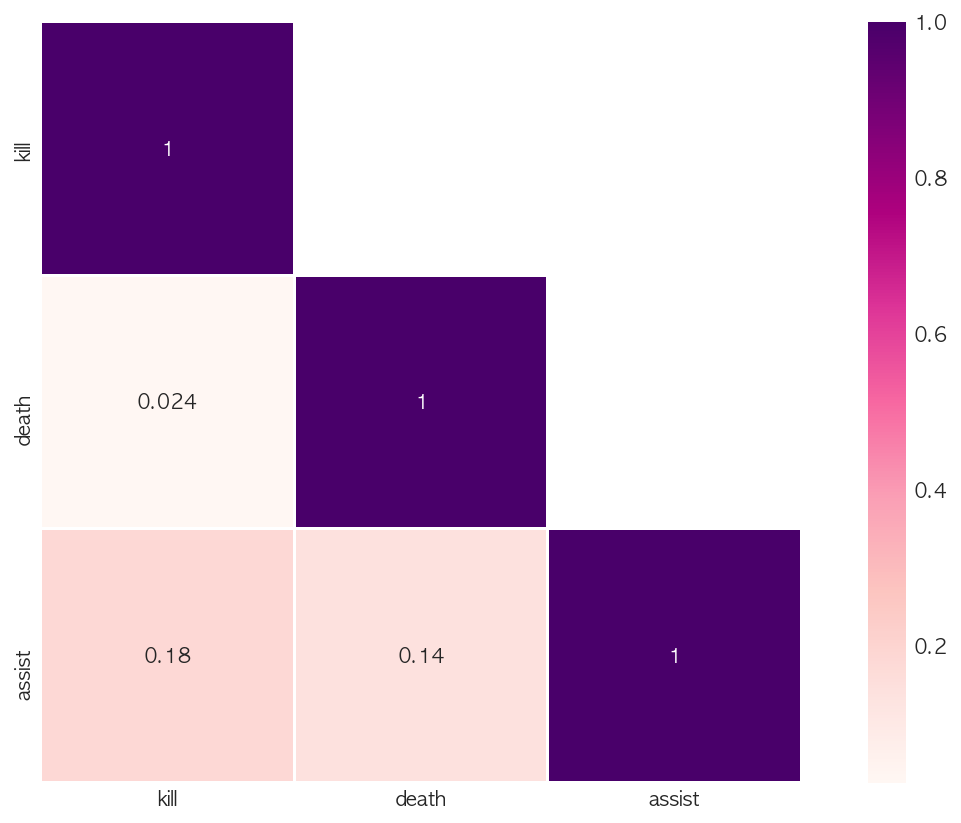

In [8]:
corr_matt = train_kda.corr()
mask = np.array(corr_matt)
mask[np.tril_indices_from(mask)] = False

fig, ax = plt.subplots()
fig.set_size_inches(12, 7)
sns.heatmap(corr_matt, mask=mask, annot=True,
            square=True, linewidths=1, cmap="RdPu")
plt.show()

## 2. CS/분당 CS/와드/플레이 시간과의 상관관계

- CS와 분당 CS 모두 승리 시 높음
- 승리 시 와드 개수가 더 많음
- 게임 결과에 따른 플레이 시간은 차이 없음

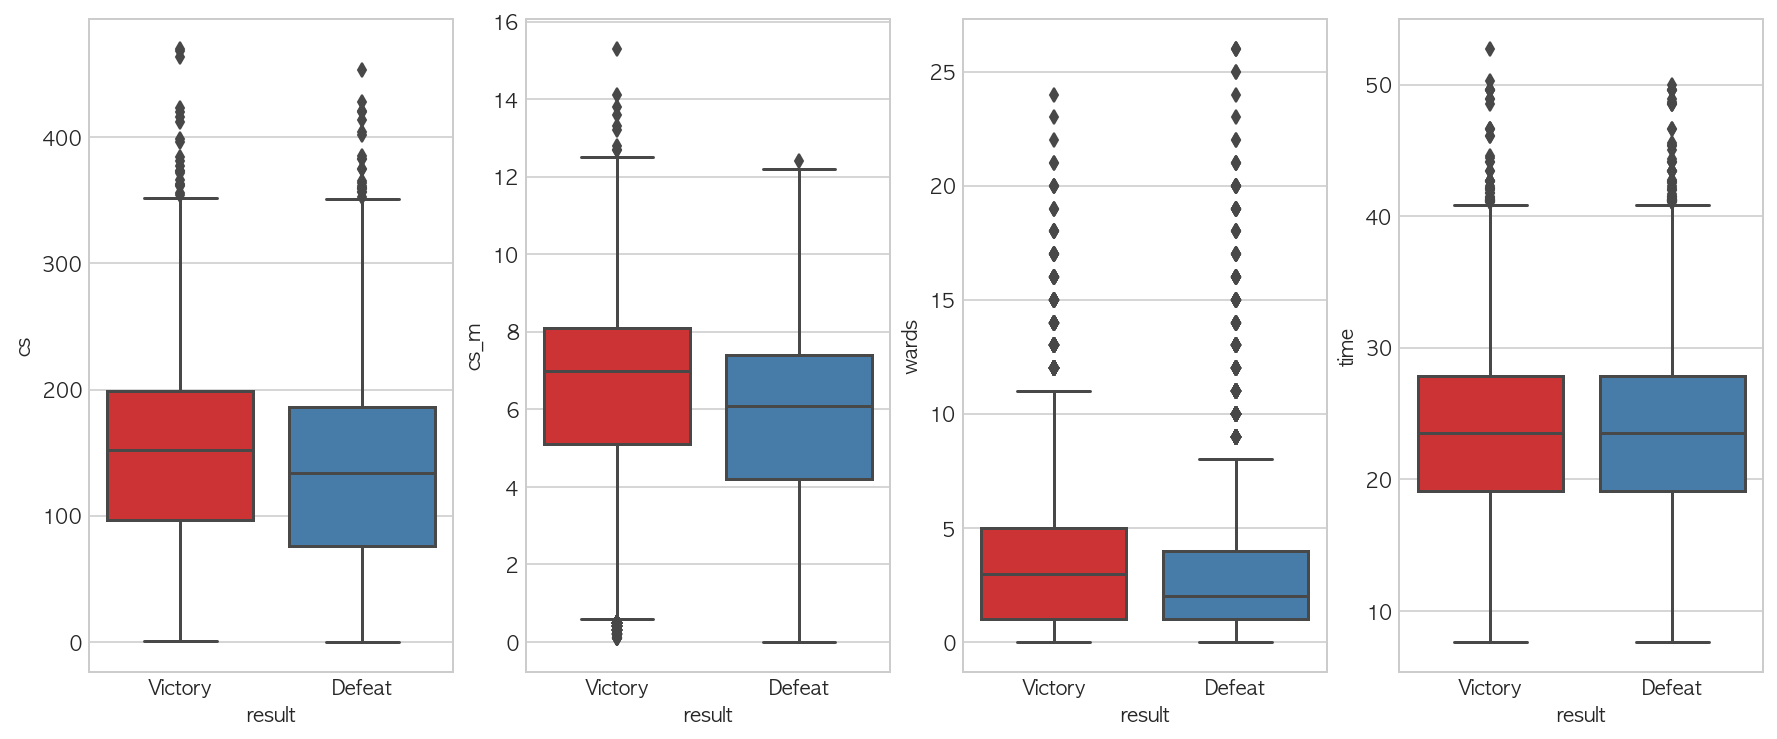

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(15, 6))

sns.boxplot(x=train['result'], y=train['cs'], palette='Set1', ax=axes[0])
sns.boxplot(x=train['result'], y=train['cs_m'], palette='Set1', ax=axes[1])
sns.boxplot(x=train['result'], y=train['wards'], palette='Set1', ax=axes[2])
sns.boxplot(x=train['result'], y=train['time'], palette='Set1', ax=axes[3])
plt.show()

- 와드를 설치한 경우 승리가 조금 더 많음
- 와드의 개수가 10개가 넘어가는 경우, 경기 후반부라 승패와 큰 상관관계가 없어 보임

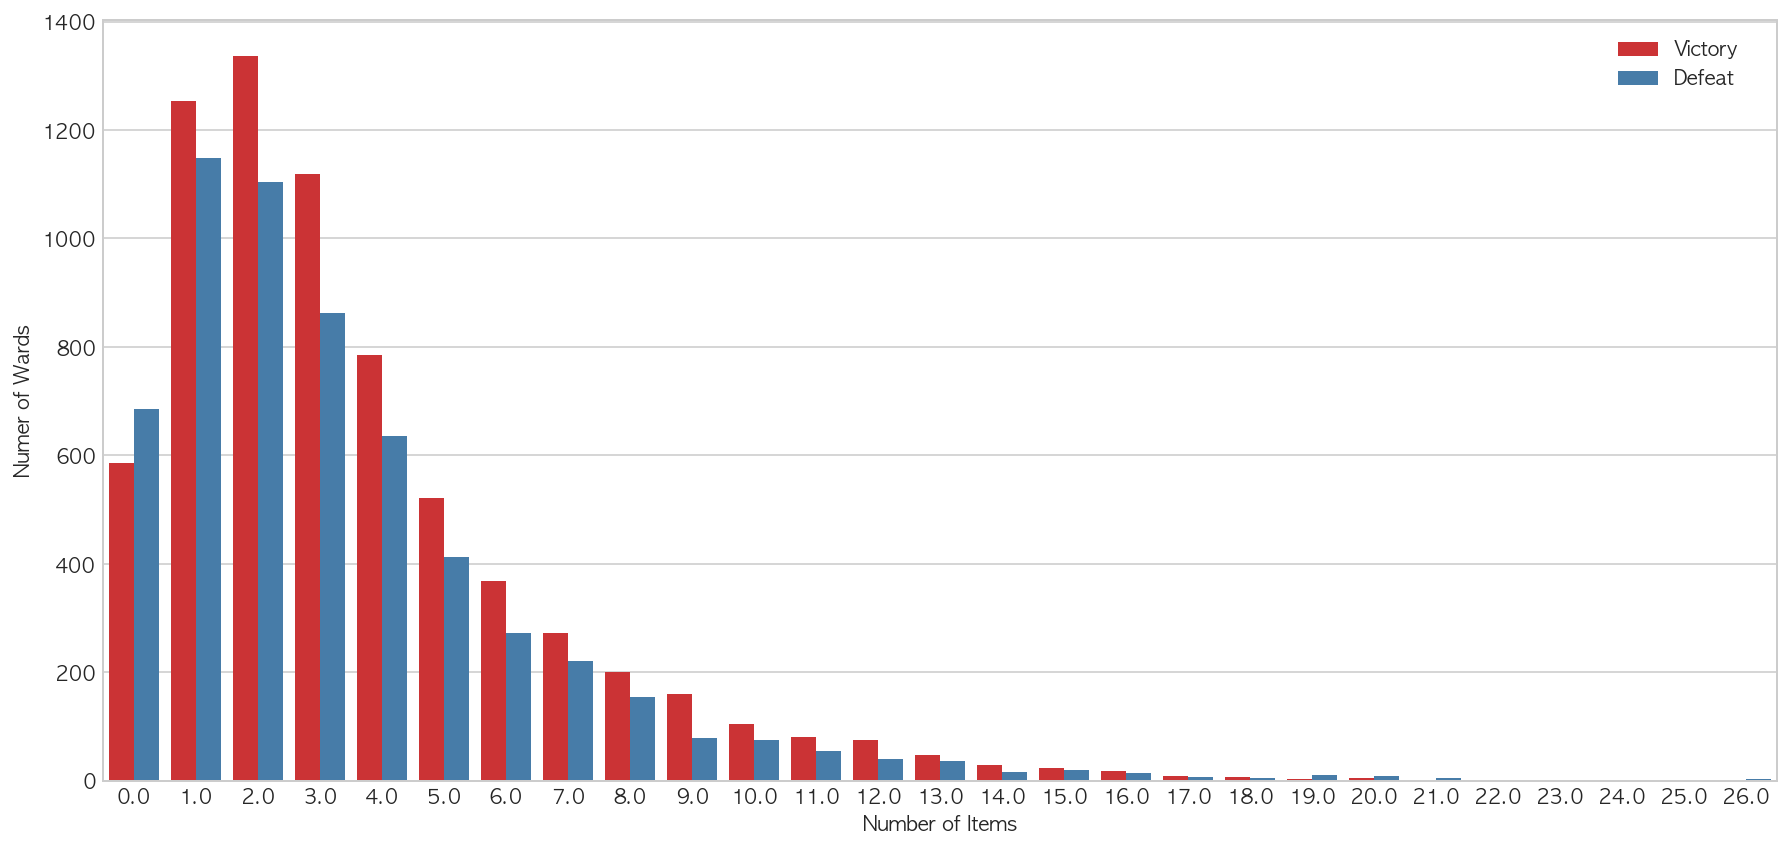

In [10]:
plt.figure(figsize=(15,7))
sns.countplot(train['wards'],
              hue='result',
              data=train,
              palette='Set1')
plt.xlabel('Number of Items')
plt.ylabel('Numer of Wards')
plt.legend(loc=(0.9, 0.9))
plt.show()

### 2.1 분당 CS는 CS의 관계
- 분당 CS는 CS에 대해 로그 함수 형태로 증가

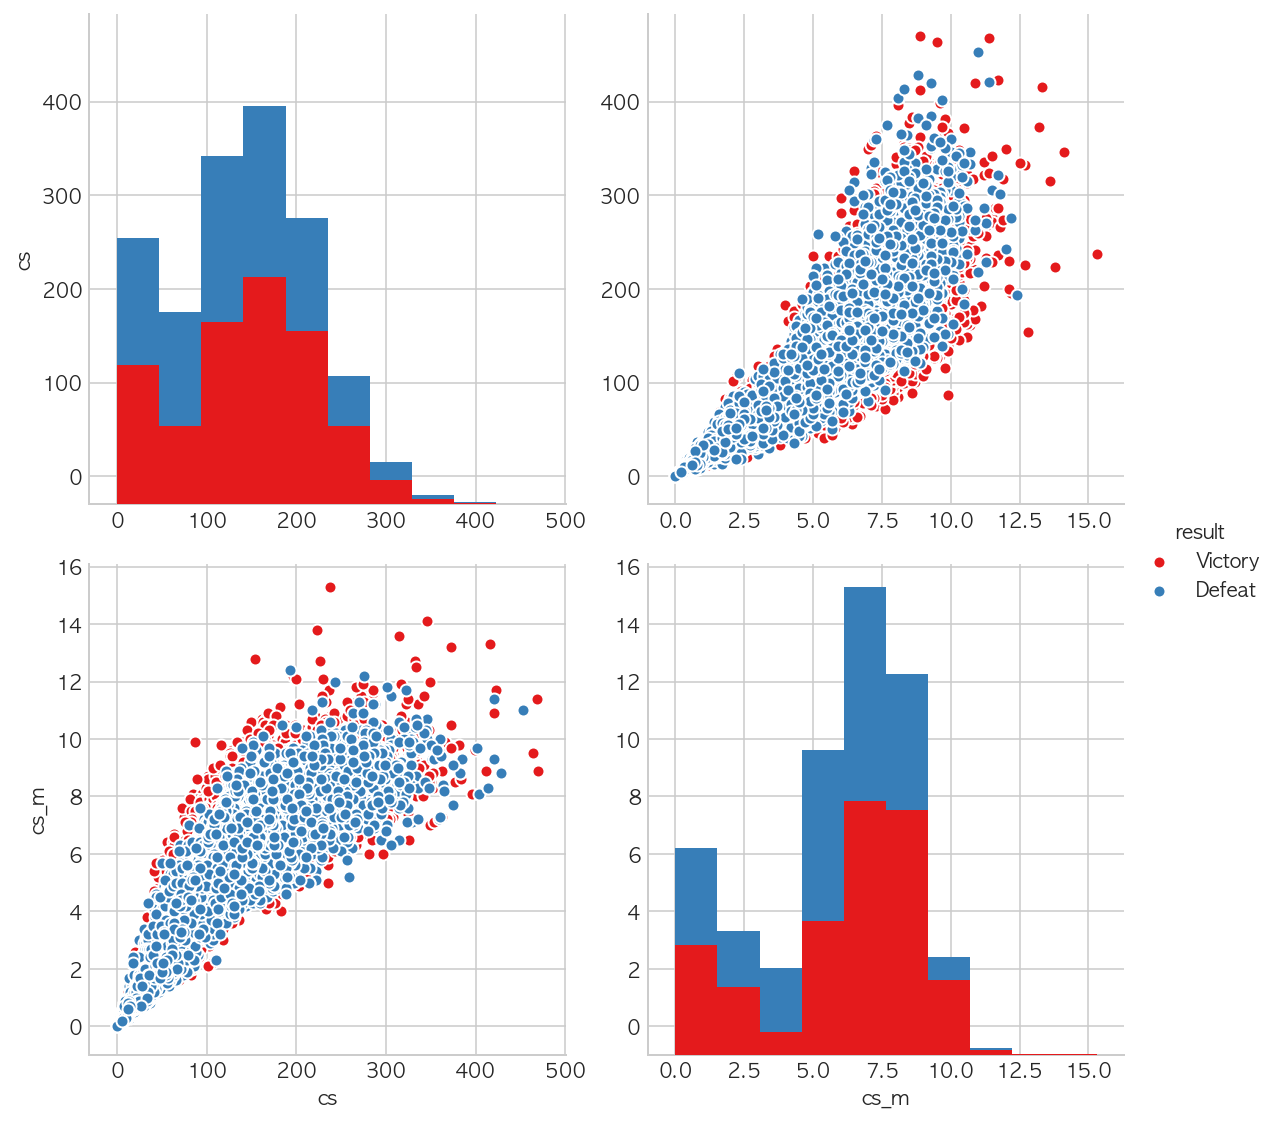

In [11]:
train_cs =  train.loc[:, ['cs', 'cs_m', 'result']]
sns.pairplot(train_cs, hue='result', palette='Set1', size=4)
plt.show()

## 3. 승패와 KDA의 상관관계

### 3.1 KDA 분포
- Perfect (Death 없음) 기록은 601건
- Perfect를 제외한 KDA 최대/최소는 35/0.14

- 전처리: 0~1로 스케일링 (sigmoid)

In [12]:
max_kda = max(train.loc[train['kda']!=np.inf]['kda'])
min_kda = min(train.loc[train['kda']]['kda'])

print(len(train[train['kda']==np.inf]))
print(max_kda)
print(min_kda)

601
35.0
0.14


- Perfect인 경우 97% 승리
- Perfect이면서 패배한 경우에는 Kill/Assist 모두 이긴 경우보다 낮았음

In [13]:
train[train['kda']==np.inf]['result'].value_counts()

Victory    585
Defeat      16
Name: result, dtype: int64

In [14]:
perf = train[train['kda']==np.inf]
perf_defeat = perf[perf['result']=='Defeat']
perf_defeat.head()

,result,time,kill,death,assist,kda,p_kill,wards,cs,cs_m
934,Defeat,7.93,0.0,0.0,1.0,inf,0.50,0.0,24.0,3.0
1457,Defeat,18.98,1.0,0.0,5.0,inf,0.67,6.0,31.0,1.6
1652,Defeat,14.98,3.0,0.0,3.0,inf,0.55,1.0,16.0,1.1
2600,Defeat,28.38,3.0,0.0,2.0,inf,0.50,4.0,232.0,8.2
2612,Defeat,15.85,1.0,0.0,1.0,inf,0.40,1.0,133.0,8.4


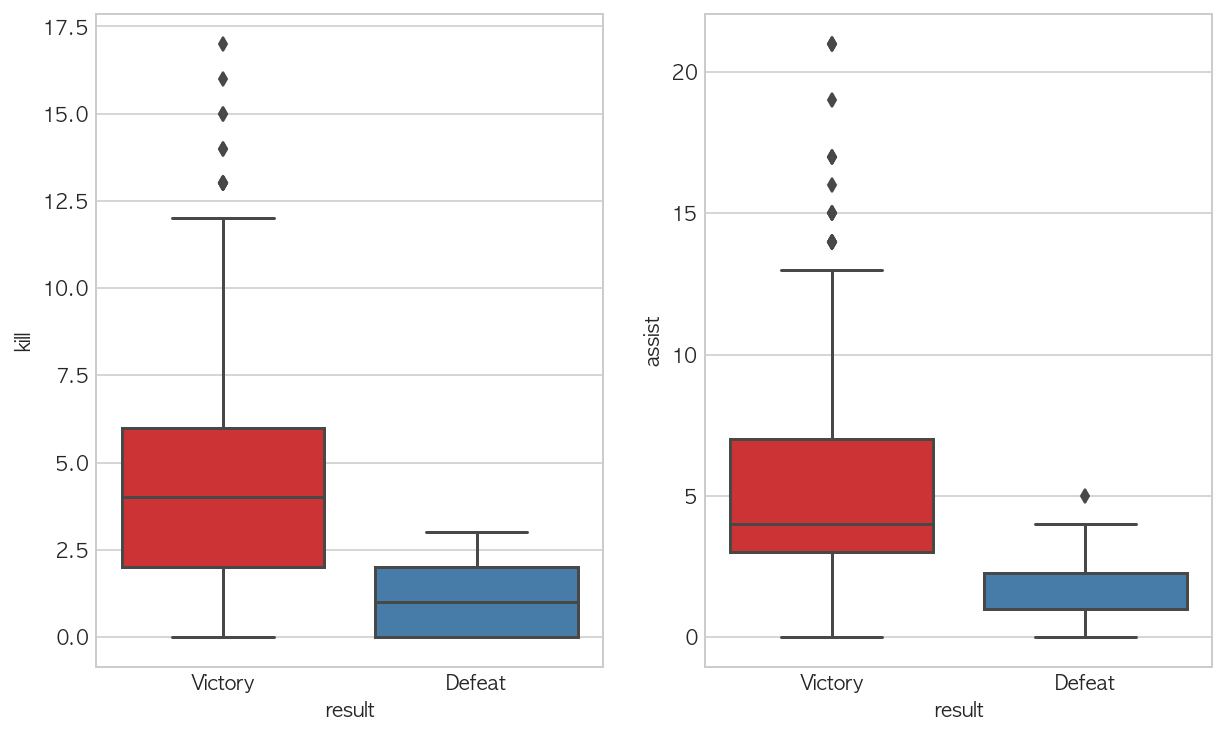

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

sns.boxplot(x=perf['result'], y=train['kill'], palette='Set1', ax=axes[0])
sns.boxplot(x=perf['result'], y=train['assist'], palette='Set1', ax=axes[1])
plt.show()

In [16]:
train[train['kda']==max_kda]

,result,time,kill,death,assist,kda,p_kill,wards,cs,cs_m
7076,Victory,37.63,8.0,1.0,27.0,35.0,0.76,4.0,291.0,7.7


In [17]:
train[train['kda']==min_kda]

,result,time,kill,death,assist,kda,p_kill,wards,cs,cs_m
4,Defeat,15.28,0.0,7.0,1.0,0.14,0.11,1.0,53.0,3.5
2182,Defeat,21.00,1.0,7.0,0.0,0.14,0.20,3.0,97.0,4.6
2514,Defeat,15.43,1.0,7.0,0.0,0.14,0.13,3.0,24.0,1.6
2986,Defeat,18.43,1.0,7.0,0.0,0.14,0.11,1.0,121.0,6.6
3687,Defeat,18.77,0.0,7.0,1.0,0.14,0.13,0.0,92.0,4.9
3758,Defeat,20.60,1.0,7.0,0.0,0.14,0.11,1.0,145.0,7.0
3846,Defeat,16.37,1.0,7.0,0.0,0.14,0.20,3.0,109.0,6.7
4347,Defeat,27.47,0.0,7.0,1.0,0.14,0.06,4.0,231.0,8.4
4581,Defeat,16.47,1.0,7.0,0.0,0.14,0.10,0.0,114.0,6.9
5707,Defeat,21.30,1.0,7.0,0.0,0.14,0.09,0.0,118.0,5.5


- Perfect KDA는 최댓값으로 Padding (KDA 3 이상은 큰 의미가 없다고 판단)

In [18]:
idx = train['kda']==np.inf
train.loc[idx, 'kda'] = max_kda
len(train[train['kda']==np.inf])

0

### 3.2 KDA 1 (1인분) 이상/미만 경우

- KDA 1 이상일 경우, 승리할 확률 증가
- KDA 1 미만인 경우에는 대부분 패배

In [19]:
kda_over_1 = train[train['kda'] >= 1.00]
kda_under_1 = train[train['kda'] < 1.00]

print(len(kda_over_1))
print(len(kda_under_1))

11059
1820


In [20]:
victory = train['result'].value_counts()[0]
defeat = train['result'].value_counts()[1]

r_victory = victory / len(train)
r_defeat = defeat / len(train)

print(round(r_victory, 2), round(r_defeat, 2))

0.54 0.46


In [21]:
print('KDA 1이상인 경우 승패: ')
print(dict(kda_over_1['result'].value_counts()))
print('')
print('KDA 1이하인 경우 승패: ')
print(dict(kda_under_1['result'].value_counts()))

KDA 1이상인 경우 승패: 
{'Victory': 6942, 'Defeat': 4117}

KDA 1이하인 경우 승패: 
{'Defeat': 1758, 'Victory': 62}


In [22]:
victory = kda_over_1['result'].value_counts()[0]
defeat = kda_over_1['result'].value_counts()[1]

r_victory = victory / len(kda_over_1)
r_defeat = defeat / len(kda_over_1)

print(round(r_victory, 2), round(r_defeat, 2))

0.63 0.37


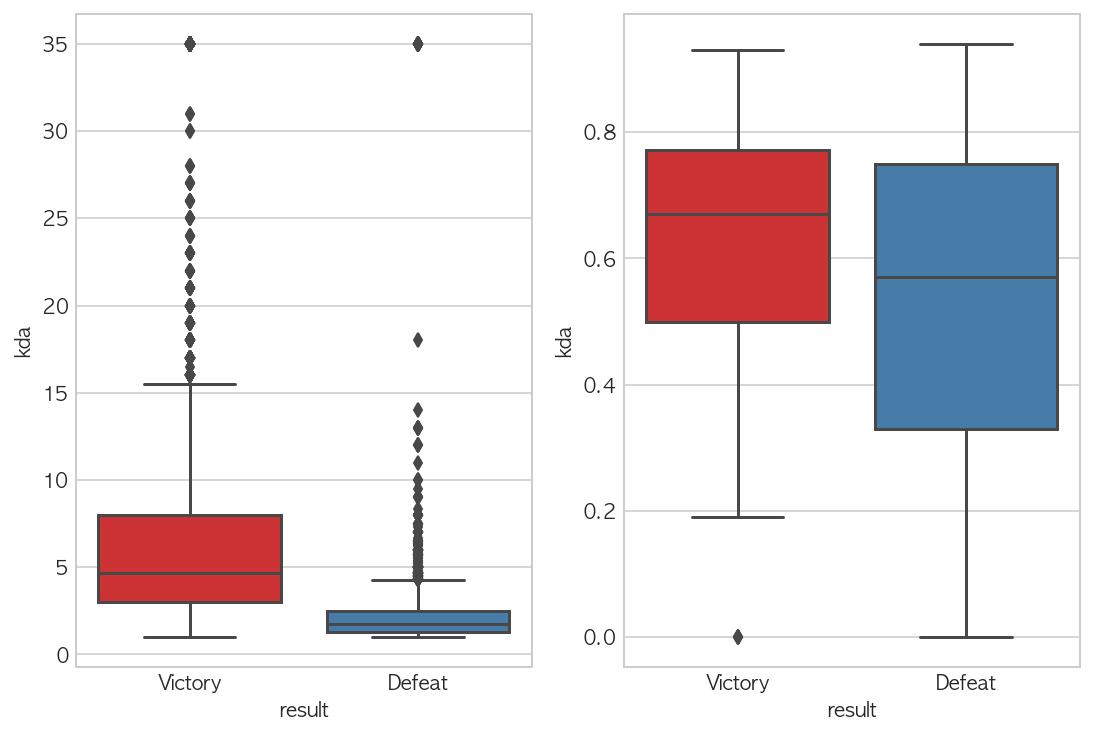

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(9, 6))

sns.boxplot(x=kda_over_1['result'], y=train['kda'],
            palette='Set1', ax=axes[0])
sns.boxplot(x=kda_under_1['result'], y=train['kda'],
            order=['Victory', 'Defeat'], palette='Set1', ax=axes[1])
plt.show()

### 3.3 승패와 구간별 KDA

- KDA 2 미만이면 패배가 더 많음
- KDA 2점대에서는 승패가 비슷
- KDA 3이상에서는 승리가 더 많음

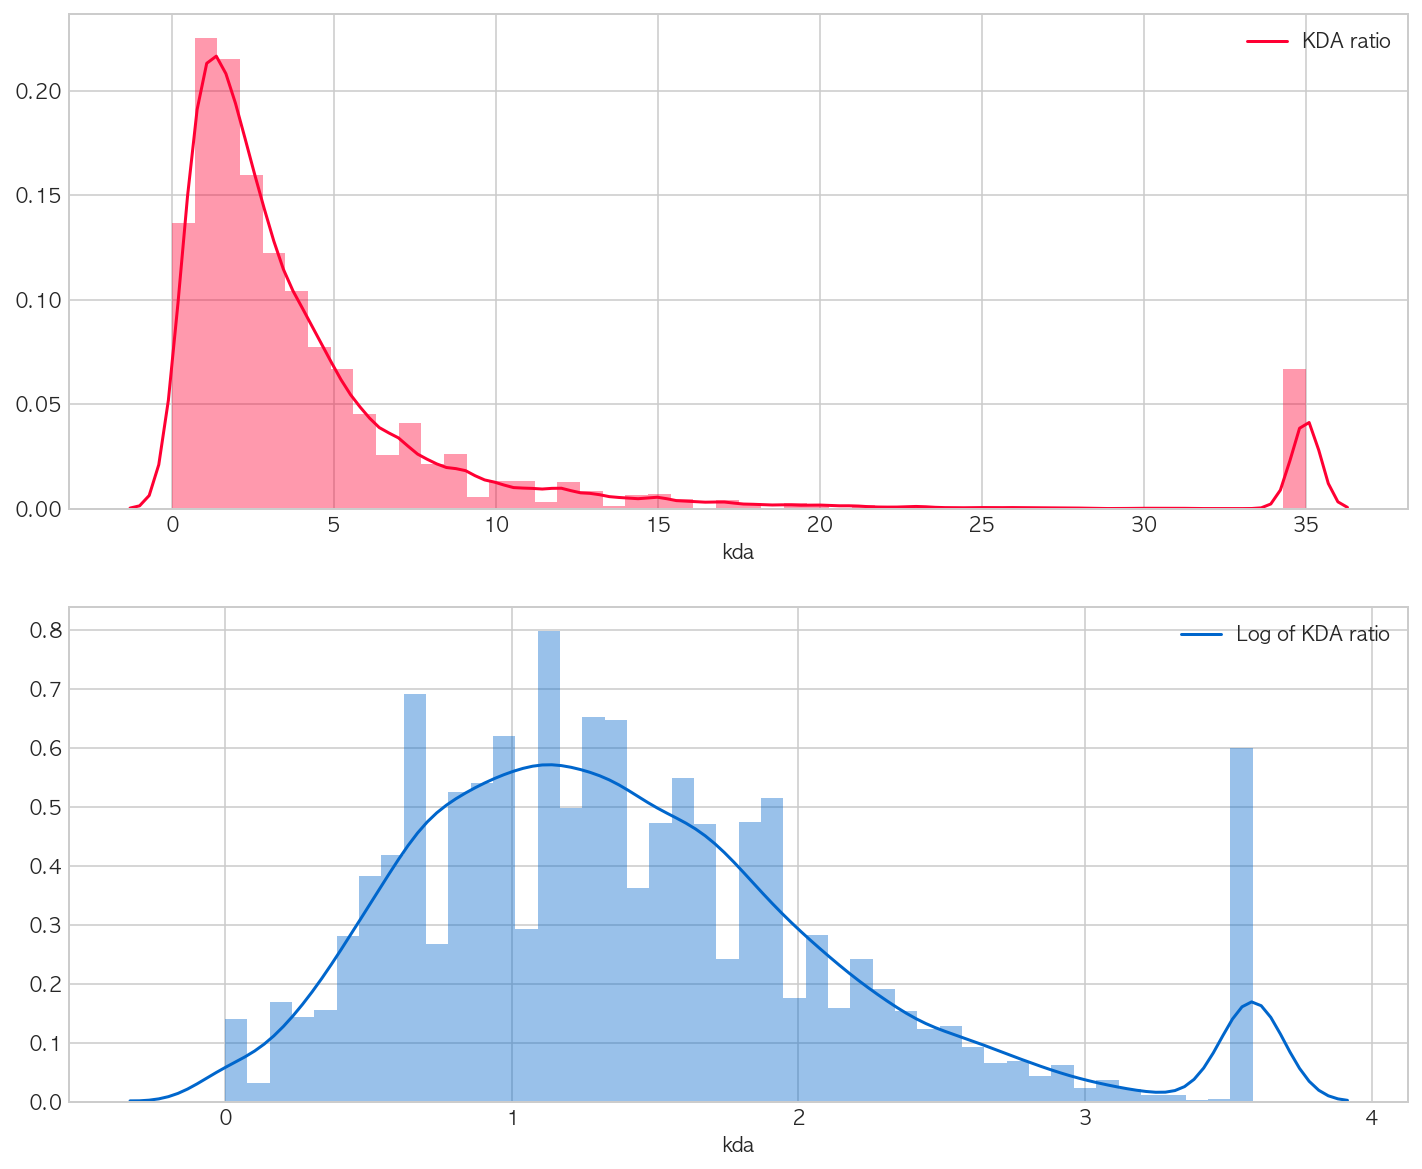

In [24]:
plt.figure(figsize=(12, 10))

plt.subplot(211)
sns.distplot(train[train['kda']!=np.inf]['kda'], 
             color=colors[0],
             kde_kws={'label': 'KDA ratio'})
plt.subplot(212)
sns.distplot(np.log1p(train[train['kda']!=np.inf]['kda']), 
             color=colors[1],
             kde_kws={'label': 'Log of KDA ratio'})
plt.show()

In [25]:
train['kda_range'] = train['kda'].apply(categorize_kda)
train['kda_range'].value_counts()

3    6054
1    2853
2    2152
0    1820
Name: kda_range, dtype: int64

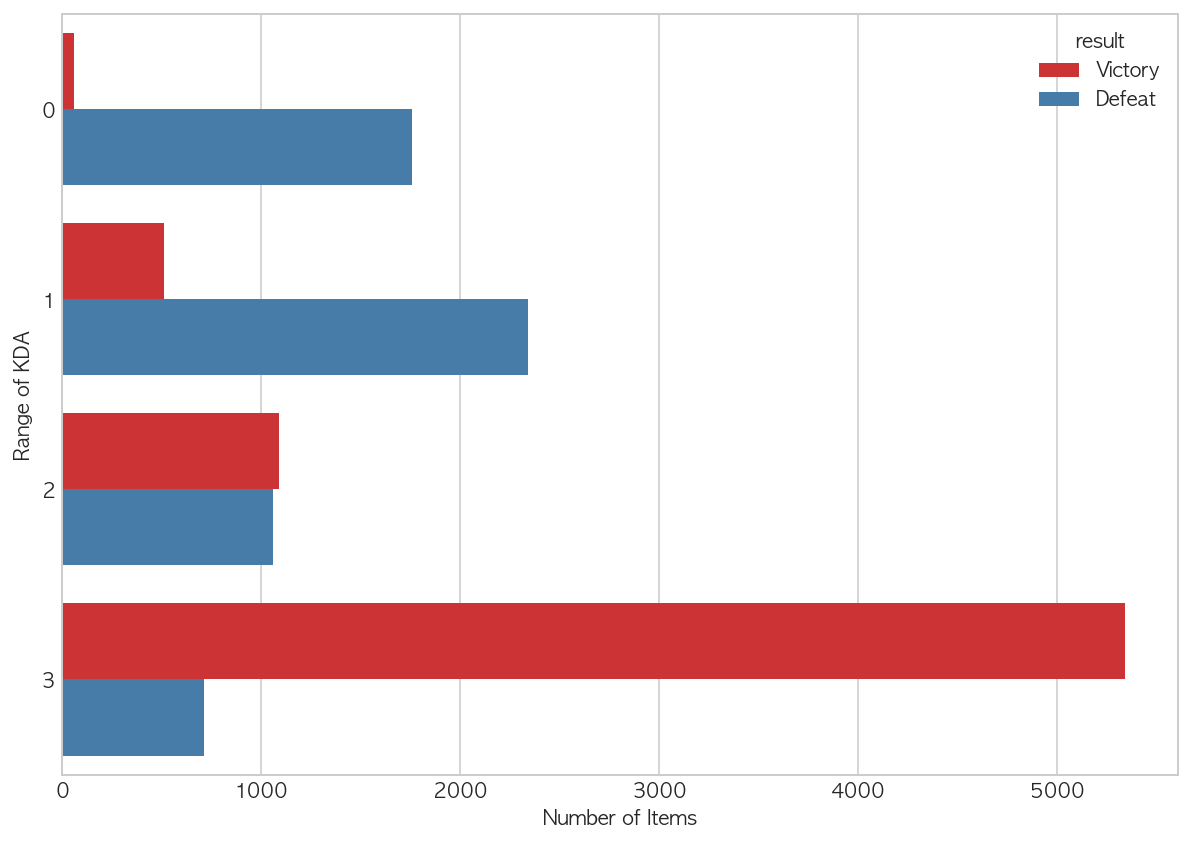

In [26]:
plt.figure(figsize=(10,7))
sns.countplot(y=train['kda_range'],
              hue='result',
              data=train,
              palette='Set1')
plt.xlabel('Number of Items')
plt.ylabel('Range of KDA')
plt.show()

## 4. 전체 변수간 상관관계

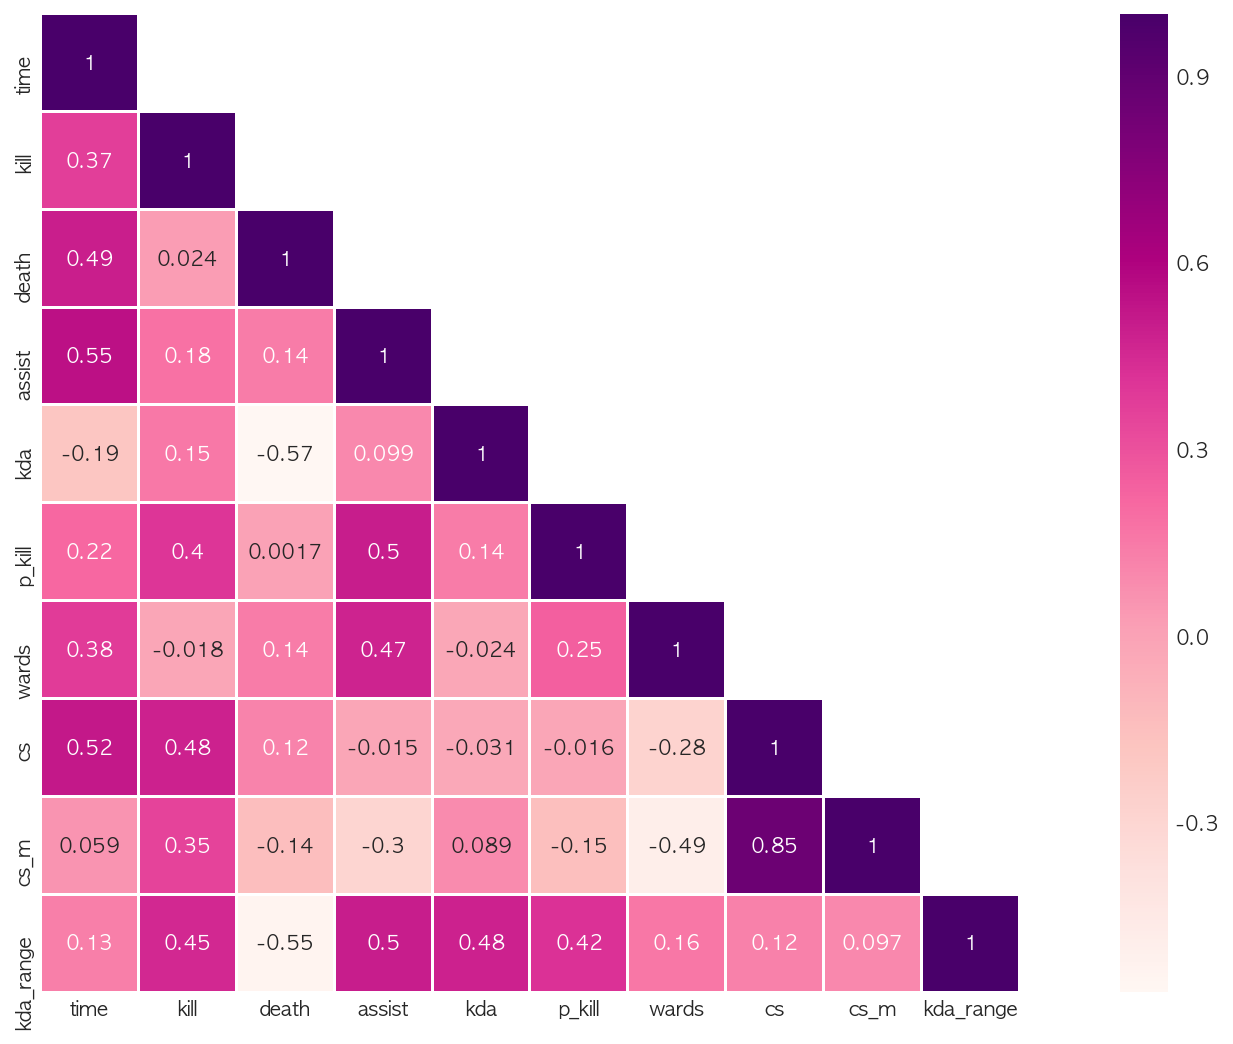

In [27]:
matt = train.iloc[:, 1:]

corr_matt = matt.corr()
mask = np.array(corr_matt)
mask[np.tril_indices_from(mask)] = False

fig, ax = plt.subplots()
fig.set_size_inches(18, 9)
sns.heatmap(corr_matt, mask=mask, annot=True,
            square=True, linewidths=1, cmap="RdPu")
plt.show()